# RNN for Name Entity Recognition

## Inicialize

In [ ]:
pip install -U sentence-transformers transformers

Librerias

In [ ]:
import json
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer

Usamos el GPU si existe

In [ ]:
if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)

Cargamos los modelos y los datasets

In [ ]:
drive.mount('/content/drive')
Mpnet2 = SentenceTransformer('all-mpnet-base-v2')
DistilRoBERTa = SentenceTransformer('hackathon-pln-es/paraphrase-spanish-distilroberta')
test = json.load(open("/content/drive/MyDrive/Colab Notebooks/Dataset/ner_promed_test.json"))
train = json.load(open("/content/drive/MyDrive/Colab Notebooks/Dataset/ner_promed_train.json"))

Seteamos una variables iniciales

In [ ]:
torch.manual_seed(1)
porcentaje_validacion = 0.2
validation = {
    "samples" : {
        "tokens" : [],
        "tags" : []
    }
}

data = train['samples'] + test['samples']
validation['samples'] = train['samples'][:int(len(train['samples'])*porcentaje_validacion)]
train['samples'] = train['samples'][int(len(train['samples'])*porcentaje_validacion):]

## Data visualize

In [ ]:
print(" ".join(train['samples'][0]['tokens']))

Título : HANTAVIRUS , SITUACIÓN EPIDEMIOLÓGICA - BRASIL . Fecha : 08 de octubre de 2004 . Hasta el 5 de septiembre de 2004 , fueron confirmados 85 casos nuevos de infección por hantavirus en Brasil del tipo del Síndrome Cardiopulmonar por Hantavirus ( SCPH ) . El número de de casos registrados hasta la fecha es equivalente al total de notificaciones en el año 2003 . Los 85 casos fueron detectados en 10 ( 37 % ) de las entidades federales , y sólo la región del Nordeste no registró casos . Cerca de 60 % de los casos fueron detectados en Minas Gerais y en el Distrito Federal . La extensión geográfica de la enfermedad está limitada a 45 áreas o municipios de transmisión , lo que equivale a 0 , 8 % del total de municipios brasileños Fueron detectados casos en todos los meses del ano , y 56 , 5 % ( 48 ) fueron registrados en el período de mayo a julio , con un incremento de casos iniciando en abril Con relación al perfil de las personas acometidas por SCPH en 2004 , 69 . 4 % ( 59 ) eran del

In [ ]:
print(" ".join(train['samples'][0]['tags']))

O O B-Disease O O O O B-Location O O O B-Date I-Date I-Date I-Date I-Date O B-Past I-Past I-Past I-Past I-Past I-Past I-Past O O O B-Number_of_cases O O O O O B-Disease O B-Location O O O B-Abreviatura I-Abreviatura I-Abreviatura I-Abreviatura I-Abreviatura I-Abreviatura I-Abreviatura O O O O O O O O O O O O O O O O O O O O O O B-Number_of_cases O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-Location I-Location O O O B-Location I-Location O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-Number_of_cases O O O O O O O B-Past I-Past I-Past O O O O O O O O O O O O O O O O O O O O O O O O O O O B-Number_of_cases O O O O O O B-Number_of_cases O O O O O O O O O B-Host I-Host I-Host I-Host I-Host I-Host O O O O O O O O O O O O B-Host I-Host I-Host I-Host I-Host O O O O O O O O O O O O O O O O O O O O O O O O O B-Disease O O O O O O O O O O O B-Location O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

Cada token tiene una clase asociada, por lo que no se debe realizar ninguna modificación a los datos originales.

## Prepare the data

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long, device=device)

Creamos word_to_ix para el modelo que no usa transformers

In [ ]:
word_to_ix = {}
for line in data:
  for word in line['tokens']:
    if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

Vemos que existen 6 clases que no tienen ni 10 repeticiones en todo el dataset

In [ ]:
tag_to_ix = {}
tag_counter = Counter()

for d in data:
    tag_counter.update(d['tags'])
for tag, count in tag_counter.most_common():
    tag_to_ix[tag] = len(tag_to_ix)
    print(f'Tag: {tag}, Repeticiones: {count}')

print(tag_to_ix)

In [ ]:
EMBEDDING_DIM = 768
HIDDEN_DIM = 32

Transformamos los tags a sus indices

In [ ]:
targets_train = []
for i in train['samples']:
  targets_train.append(prepare_sequence(i['tags'], tag_to_ix))
targets_val = []
for i in validation['samples']:
  targets_val.append(prepare_sequence(i['tags'], tag_to_ix))
targets_test = []
for i in test['samples']:
  targets_test.append(prepare_sequence(i['tags'], tag_to_ix))

# Seteamos los tags para los modelos que no usan todas las clases

targets_train_2 = [tensor * (tensor >= 12) for tensor in targets_train]
targets_val_2 = [tensor * (tensor >= 12) for tensor in targets_val]
targets_train_1 = [tensor * (tensor < 12) for tensor in targets_train]
targets_val_1 = [tensor * (tensor < 12) for tensor in targets_val]

## Model and function

Clase que utiliza un transformer como tokenizer, con lo que no necesita transformar la frase, las dimensiones del embedding son fijas y no es necesario ingresar tokens UNK o PAD

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding, hidden_dim, vocab_size, tagset_size, modelo, capas = 1):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.capas = capas
        self.modelo = modelo
        self.lstm = nn.LSTM(embedding, hidden_dim,device=device)
        self.hidden2tag1 = nn.Linear(hidden_dim, hidden_dim,device=device)
        if capas > 1: self.hidden2tag2 = nn.Linear(hidden_dim, hidden_dim,device=device)
        if capas > 2: self.hidden2tag3 = nn.Linear(hidden_dim, tagset_size,device=device)

    def forward(self, sentence):
        embeds = torch.tensor(self.modelo.encode(sentence,batch_size=128,device=device),device=device)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag1(lstm_out.view(len(sentence), -1))
        if self.capas > 1: tag_space = self.hidden2tag2(lstm_out.view(len(sentence), -1))
        if self.capas > 2: tag_space = self.hidden2tag3(tag_space)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Creamos un modelo simple que se entrena iterativamente (no por batch), con capacidad de tener 3 capas de MLP y un LSTM

In [ ]:
class LSTMTagger2(nn.Module):

    def __init__(self, embedding, hidden_dim, vocab_size, tagset_size, capas = 1):
        super(LSTMTagger2, self).__init__()
        self.hidden_dim = hidden_dim
        self.capas = capas
        self.word_embeddings = nn.Embedding(vocab_size, embedding, device=device)
        self.lstm = nn.LSTM(embedding, hidden_dim,device=device)
        self.hidden2tag1 = nn.Linear(hidden_dim, hidden_dim,device=device)
        if capas > 1: self.hidden2tag2 = nn.Linear(hidden_dim, hidden_dim,device=device)
        if capas > 2: self.hidden2tag3 = nn.Linear(hidden_dim, tagset_size,device=device)

    def forward(self, sentence):
        embeds = self.word_embeddings(prepare_sequence(sentence, word_to_ix))
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag1(lstm_out.view(len(sentence), -1))
        if self.capas > 1: tag_space = self.hidden2tag2(lstm_out.view(len(sentence), -1))
        if self.capas > 2: tag_space = self.hidden2tag3(tag_space)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

Codigo que nos facilita la evaluación de los modelos, podemos elejir que entrene el modelo o no y que muestre o no la matriz de confusión

In [ ]:
def evaluate(data, targets, train = False, cnf_mtrx = False):
    pred = []
    acumulative_f1 = 0
    acumulative_loss = 0
    len_samples = len(data['samples'])

    for i in range(len_samples):

        # Forward
        tag_scores = model(data['samples'][i]['tokens'])
        loss = loss_function(tag_scores, targets[i])

        matrix = []
        for j in tag_scores:                  # Sacamos el F1 macro
          matrix.append(int(j.argmax()))
        acumulative_f1 += f1_score( targets[i].tolist(),
                                    matrix,
                                    average='macro')
        if train:                             # Entrenamos de ser necesario
          loss.backward()
          optimizer.step()
          model.zero_grad()
        if cnf_mtrx: pred.append(matrix)
        acumulative_loss += loss

    if cnf_mtrx:                              # Creamos la matriz de confusión
      pred_matrix = [i for j in pred for i in j]
      targets_matrix = [i.item() for j in targets for i in j]
      matrix = confusion_matrix(targets_matrix, pred_matrix)
      r = matrix / matrix.sum(axis=1).reshape(-1, 1)
      plt.figure(figsize=(10, 8))
      ax = sns.heatmap(r, cmap=plt.cm.Blues, annot=True);

    return  round(acumulative_f1/len_samples,2), round(acumulative_loss.item()/len_samples,2)

## Experiments

Transformer usado: DistilRoBERTa

Neuronas ocultas: 32

Capas MLP : 2

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, 32, len(word_to_ix), len(tag_to_ix), DistilRoBERTa, 2)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(15):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

Transformer usado: DistilRoBERTa

Neuronas ocultas: 32

Capas MLP : 1

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, 32, len(word_to_ix), len(tag_to_ix), DistilRoBERTa, 1)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(15):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

Transformer usado: Mpnet2

Neuronas ocultas: 32

Capas MLP : 2

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, 32, len(word_to_ix), len(tag_to_ix), Mpnet2, 2)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(15):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

Transformer usado: DistilRoBERTa

Neuronas ocultas: 64

Capas MLP : 2

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, 64, len(word_to_ix), len(tag_to_ix), DistilRoBERTa, 2)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(15):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

Transformer usado: Tokenizer sin entrenar (sin transformer)

Neuronas ocultas: 32

Capas MLP: 3

In [ ]:
model = LSTMTagger2(EMBEDDING_DIM, 32, len(word_to_ix), len(tag_to_ix), 3)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

for epoch in range(50):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

Transformer usado: Tokenizer sin entrenar (sin transformer)

Neuronas ocultas: 32

Capas MLP: 1

In [ ]:
model = LSTMTagger2(EMBEDDING_DIM, 32, len(word_to_ix), len(tag_to_ix), 1)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

for epoch in range(50):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

Transformer usado: DistilRoBERTa

Neuronas ocultas: 32

Capas MLP: 1

"Solo tomando los parametros mayores a 13"

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, 32, len(word_to_ix), len(tag_to_ix), DistilRoBERTa, 1)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

for epoch in range(50):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train_1, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val_1, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

Transformer usado: DistilRoBERTa

Neuronas ocultas: 32

Capas MLP: 1

"Solo tomando los parametros menores a 13"

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, 32, len(word_to_ix), len(tag_to_ix), DistilRoBERTa, 1)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

for epoch in range(300):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train_2, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val_2, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()

## Train the selected model

Epoch: 0
Train, F1 macro:  0.09  Loss :  0.66
Val,   F1 macro:  0.14  Loss :  0.83


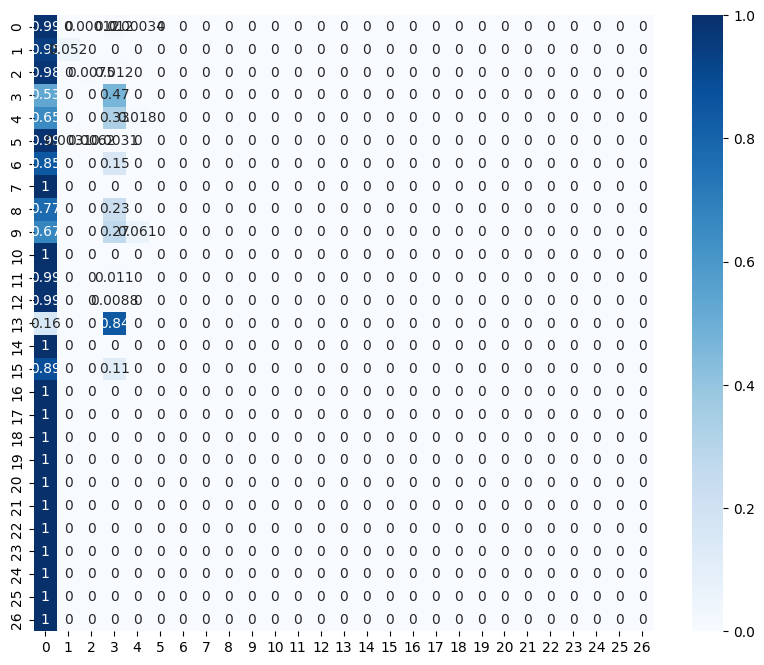

Epoch: 1
Train, F1 macro:  0.15  Loss :  0.53
Val,   F1 macro:  0.22  Loss :  0.72


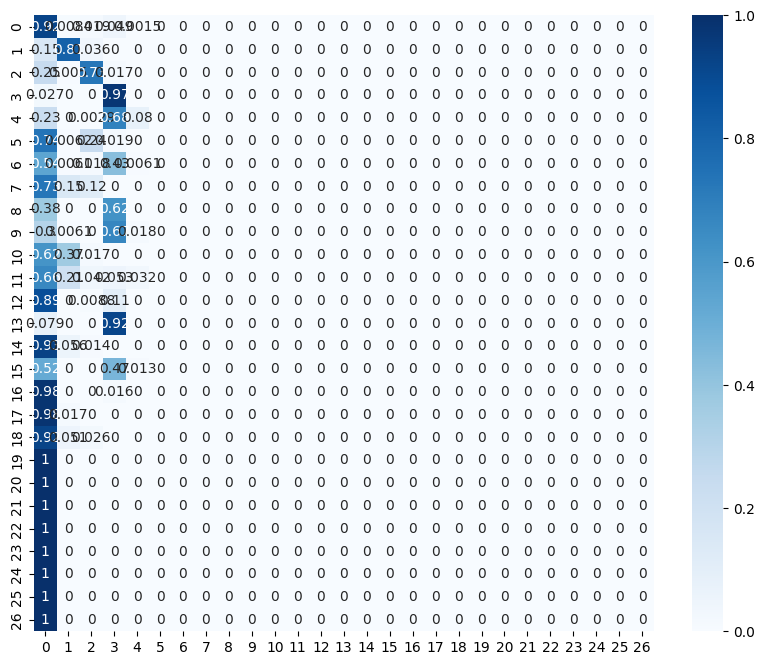

Epoch: 2
Train, F1 macro:  0.24  Loss :  0.46
Val,   F1 macro:  0.25  Loss :  0.58


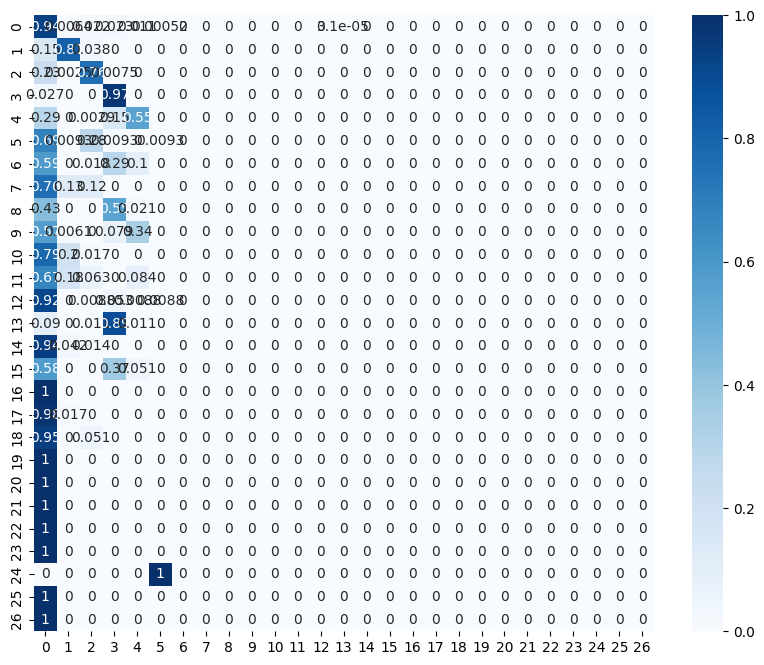

Epoch: 3
Train, F1 macro:  0.32  Loss :  0.42
Val,   F1 macro:  0.35  Loss :  0.51


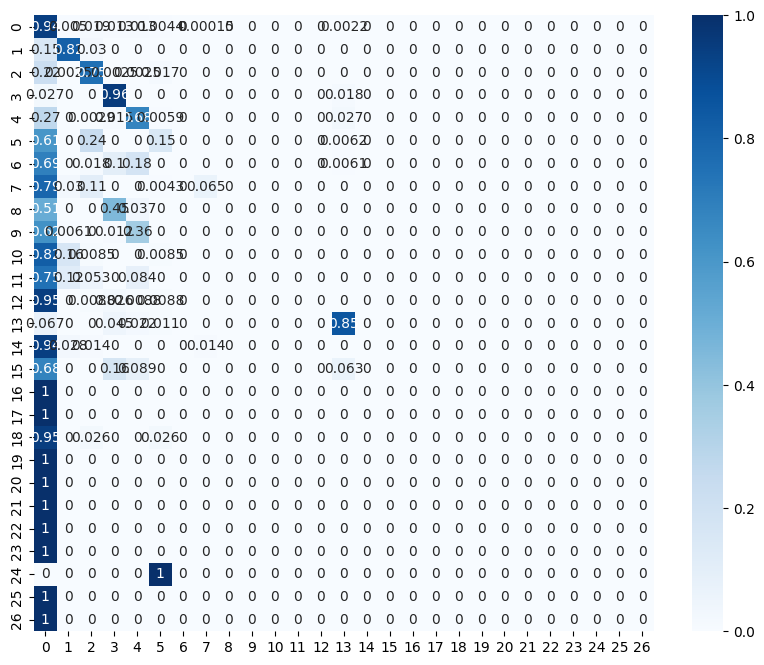

Epoch: 4
Train, F1 macro:  0.37  Loss :  0.4
Val,   F1 macro:  0.38  Loss :  0.48


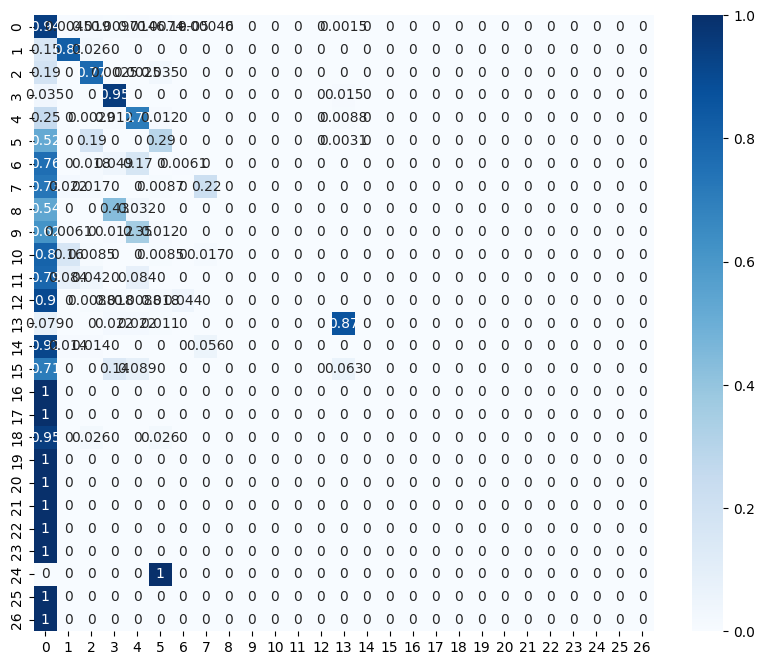

Epoch: 5
Train, F1 macro:  0.4  Loss :  0.38
Val,   F1 macro:  0.39  Loss :  0.46


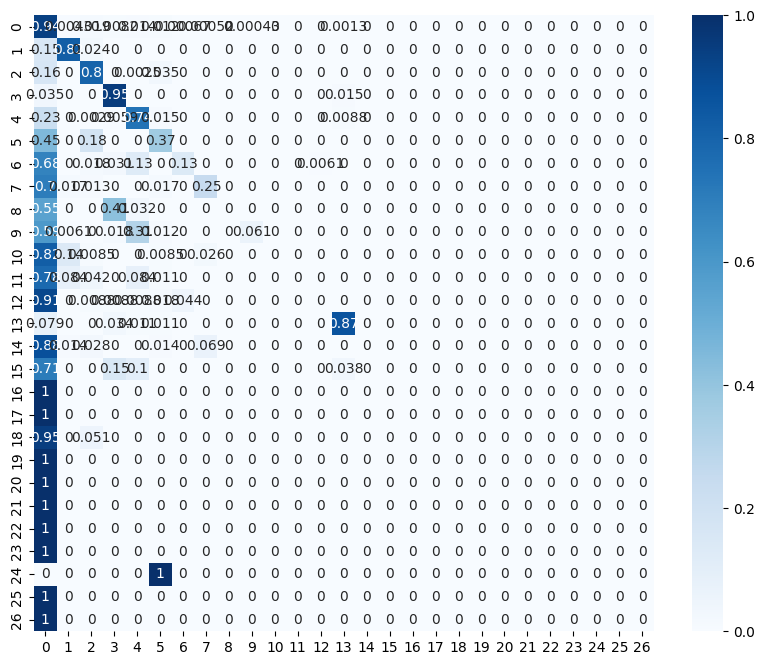

Epoch: 6
Train, F1 macro:  0.41  Loss :  0.36
Val,   F1 macro:  0.41  Loss :  0.44


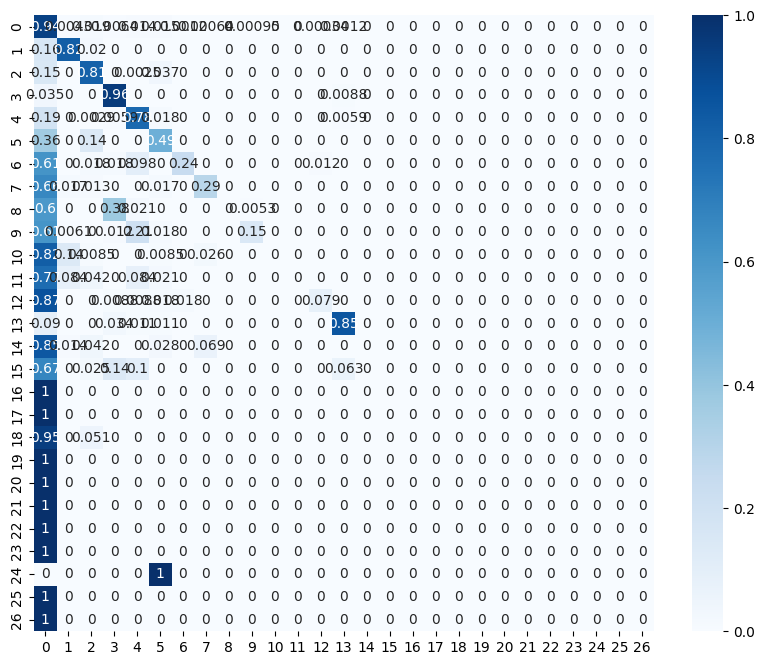

Epoch: 7
Train, F1 macro:  0.43  Loss :  0.35
Val,   F1 macro:  0.42  Loss :  0.42


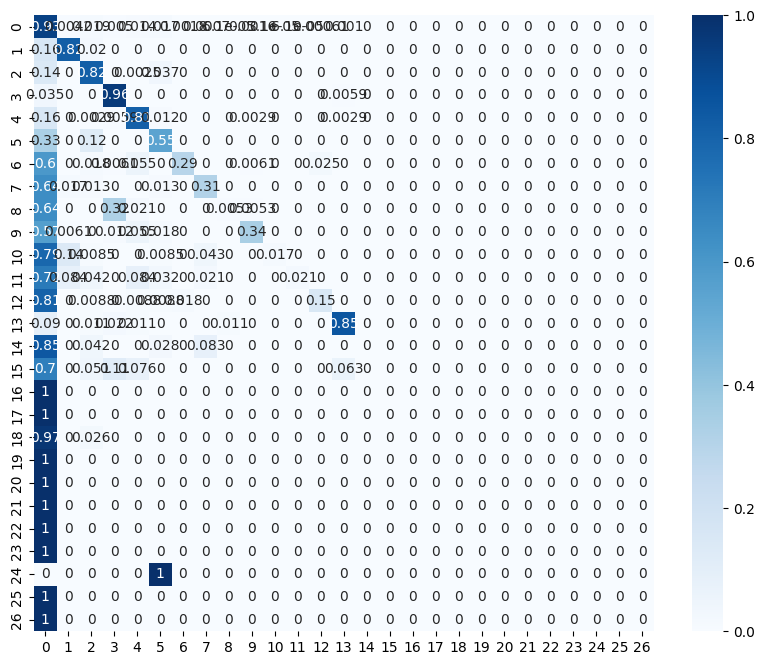

Epoch: 8
Train, F1 macro:  0.44  Loss :  0.33
Val,   F1 macro:  0.44  Loss :  0.41


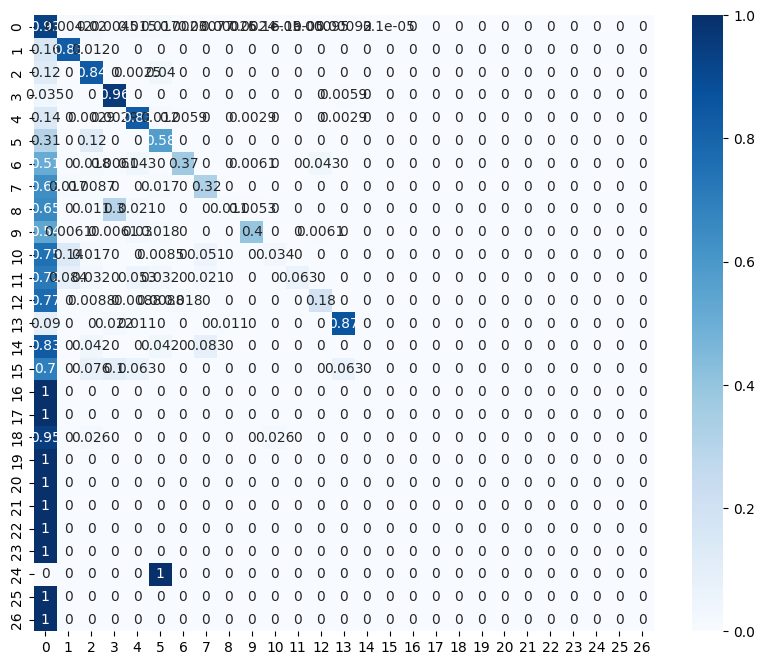

Epoch: 9
Train, F1 macro:  0.45  Loss :  0.32
Val,   F1 macro:  0.44  Loss :  0.4


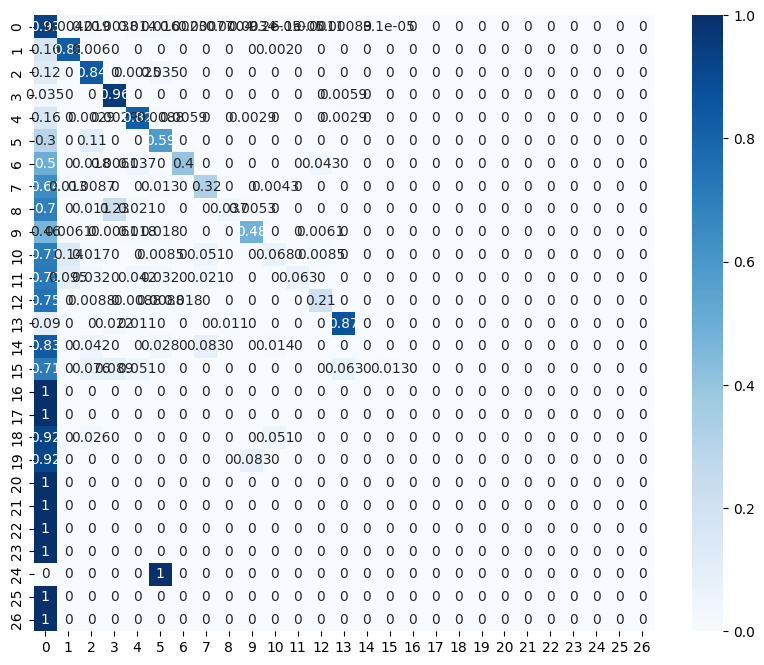

Epoch: 10
Train, F1 macro:  0.47  Loss :  0.31
Val,   F1 macro:  0.45  Loss :  0.38


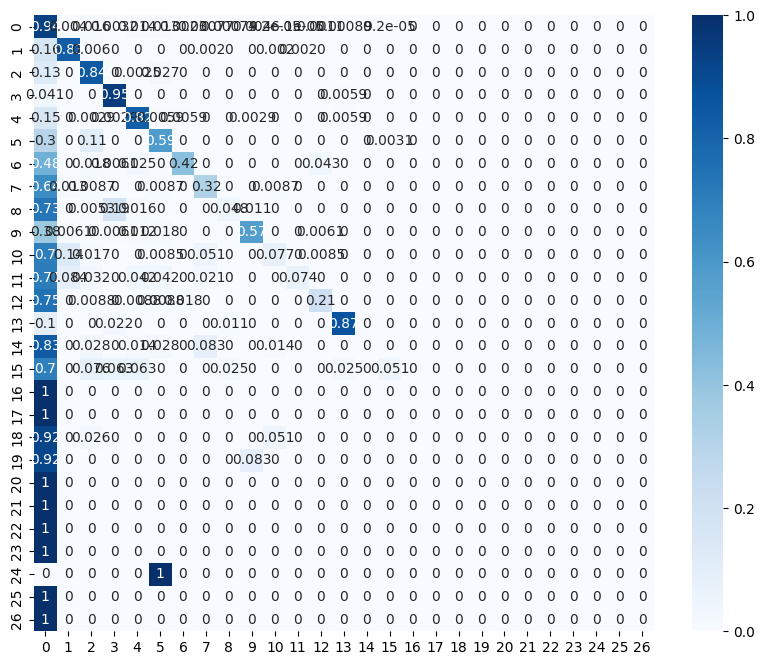

Epoch: 11
Train, F1 macro:  0.47  Loss :  0.3
Val,   F1 macro:  0.46  Loss :  0.36


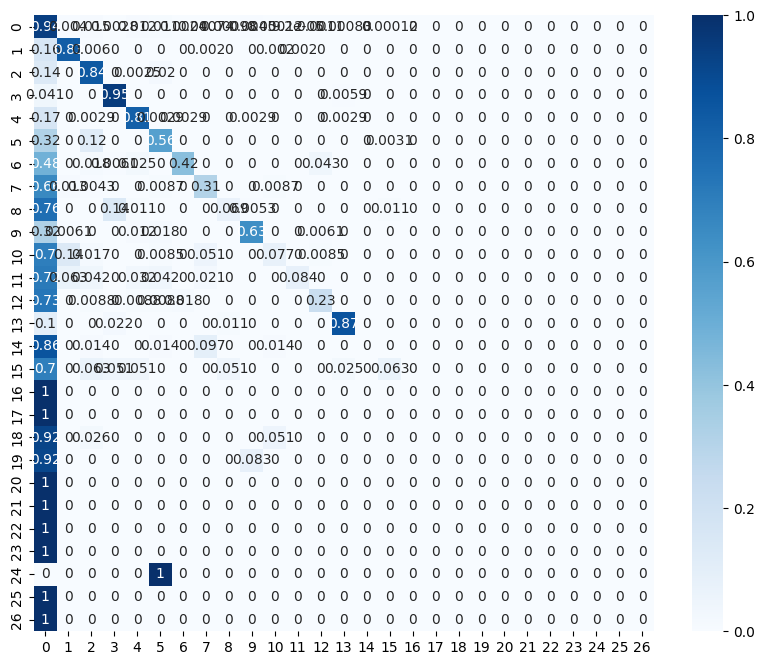

Epoch: 12
Train, F1 macro:  0.48  Loss :  0.29
Val,   F1 macro:  0.46  Loss :  0.35


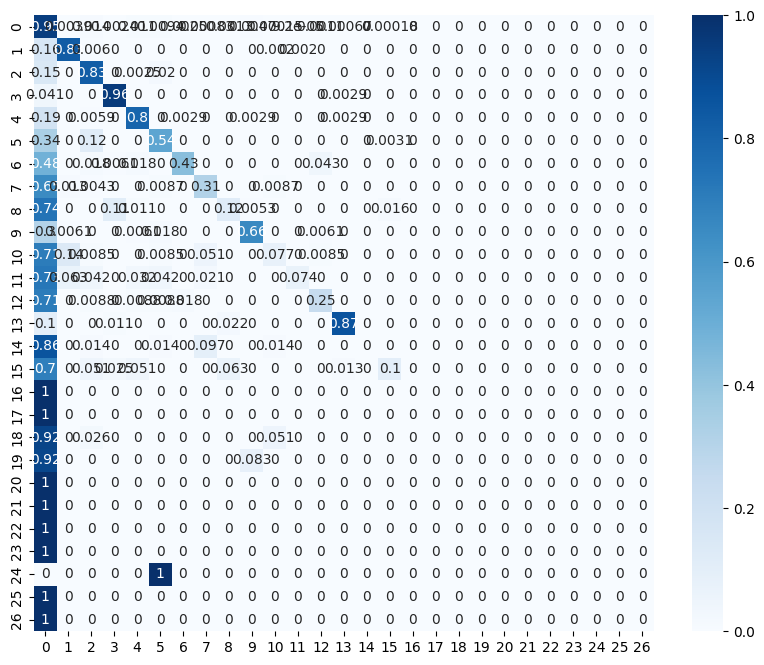

Epoch: 13
Train, F1 macro:  0.49  Loss :  0.28
Val,   F1 macro:  0.47  Loss :  0.34


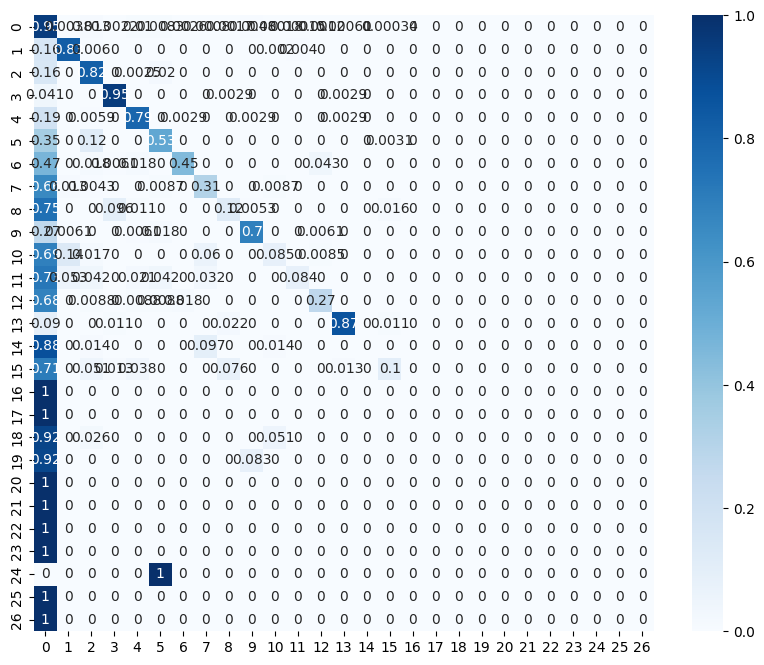

Epoch: 14
Train, F1 macro:  0.5  Loss :  0.28
Val,   F1 macro:  0.47  Loss :  0.33


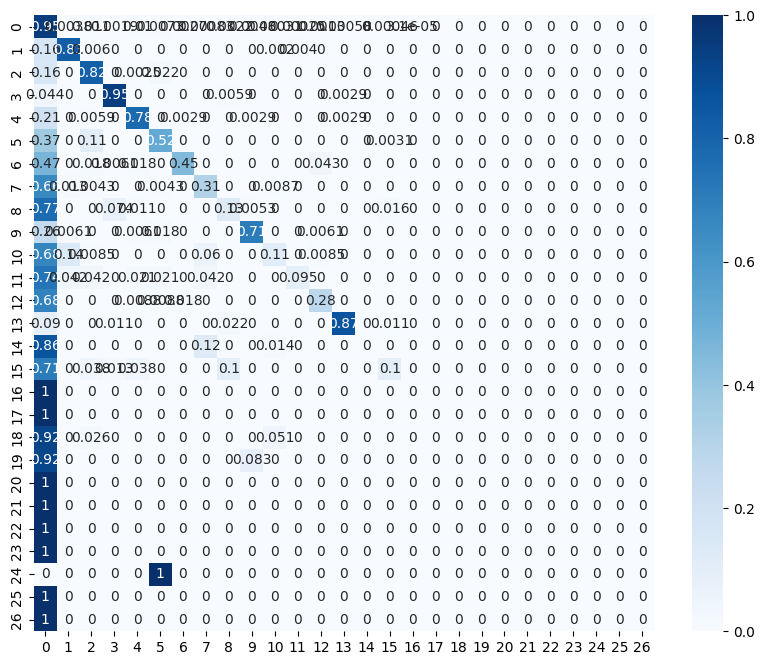

Epoch: 15
Train, F1 macro:  0.5  Loss :  0.27
Val,   F1 macro:  0.47  Loss :  0.32


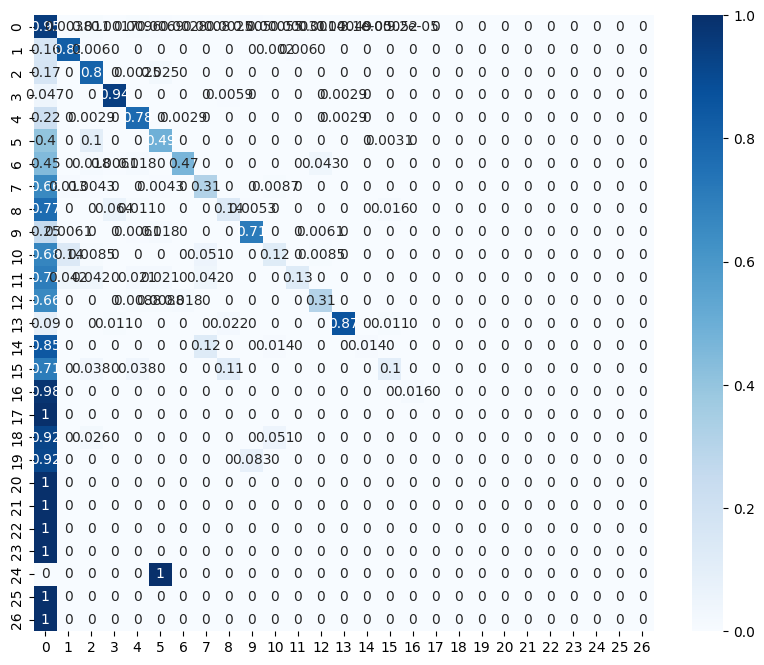

Epoch: 16
Train, F1 macro:  0.51  Loss :  0.27
Val,   F1 macro:  0.48  Loss :  0.31


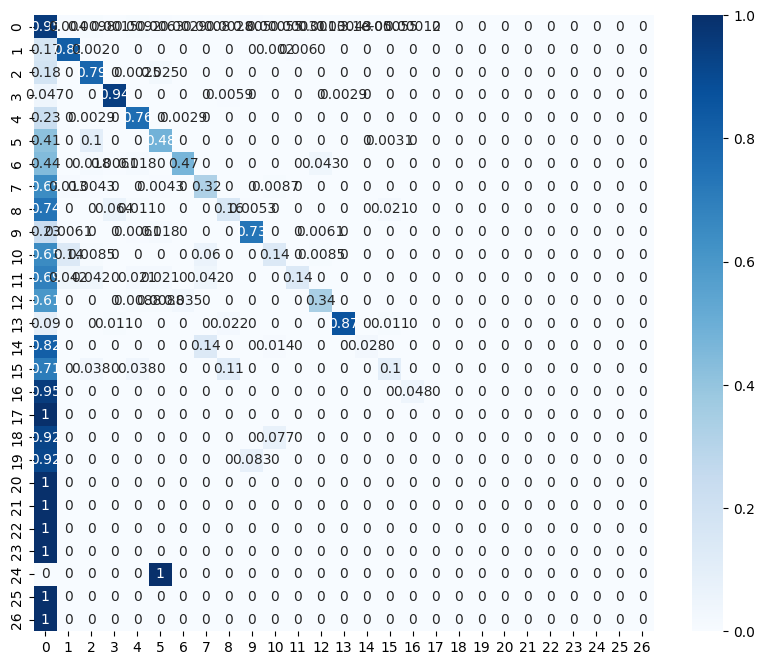

Epoch: 17
Train, F1 macro:  0.51  Loss :  0.26
Val,   F1 macro:  0.48  Loss :  0.31


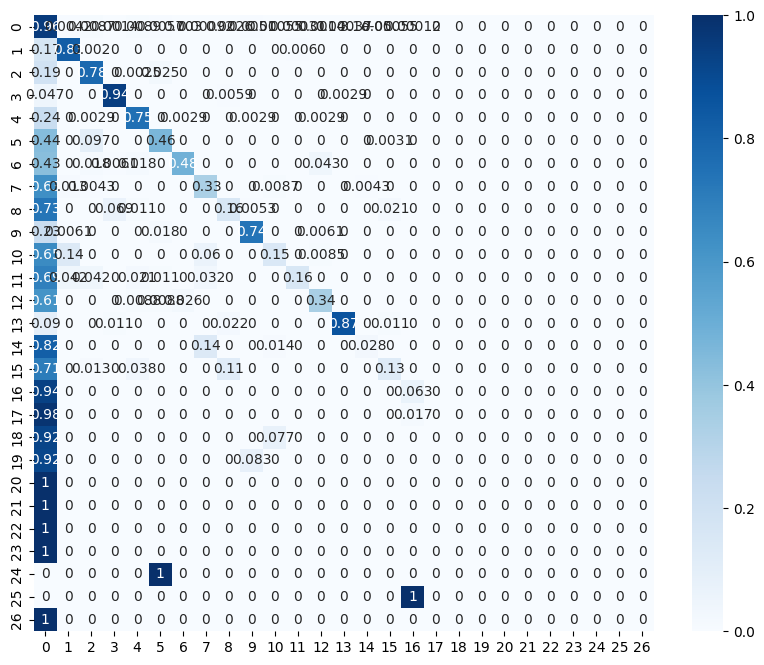

Epoch: 18
Train, F1 macro:  0.52  Loss :  0.25
Val,   F1 macro:  0.48  Loss :  0.3


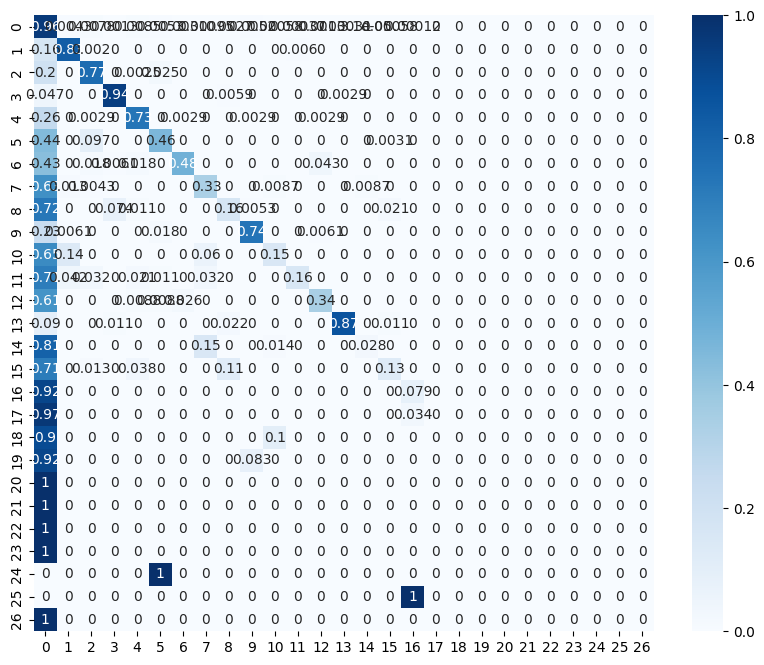

Epoch: 19
Train, F1 macro:  0.52  Loss :  0.25
Val,   F1 macro:  0.48  Loss :  0.3


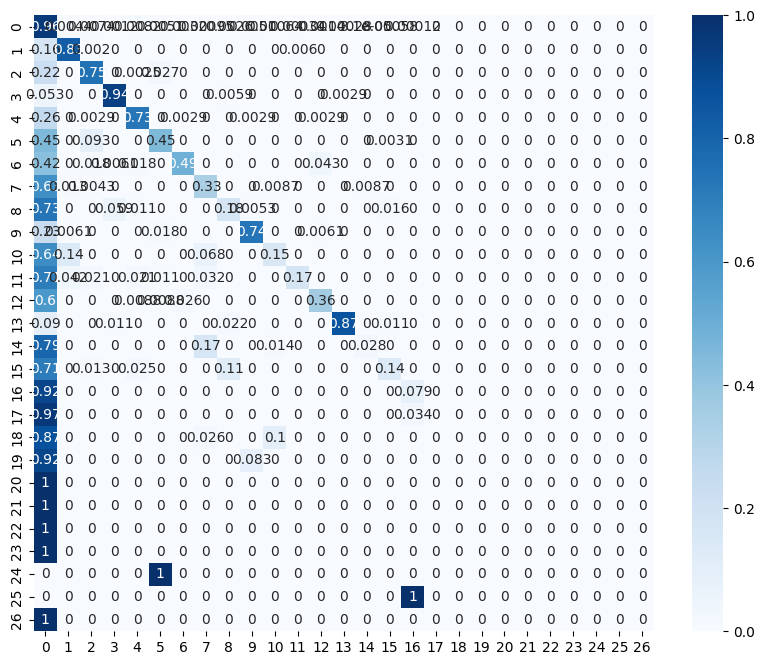

Epoch: 20
Train, F1 macro:  0.53  Loss :  0.24
Val,   F1 macro:  0.48  Loss :  0.3


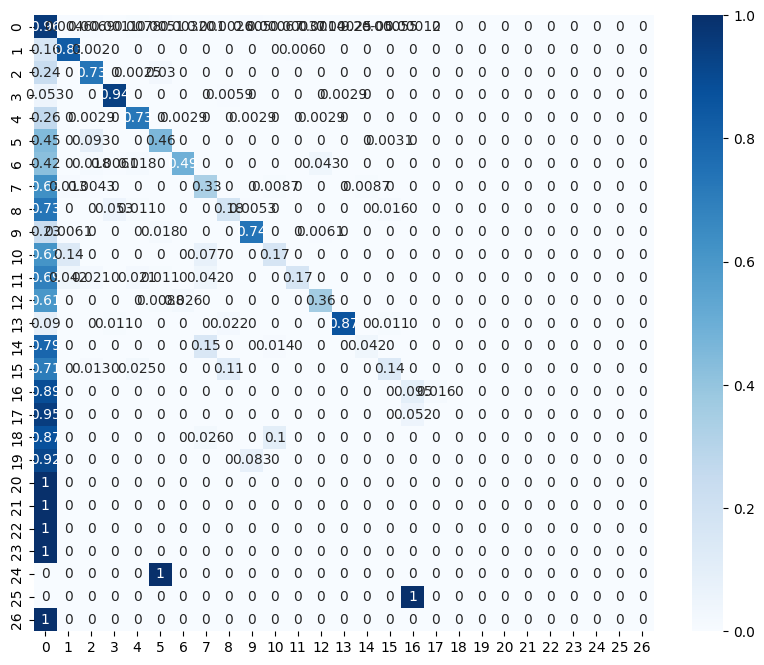

Epoch: 21
Train, F1 macro:  0.53  Loss :  0.24
Val,   F1 macro:  0.49  Loss :  0.29


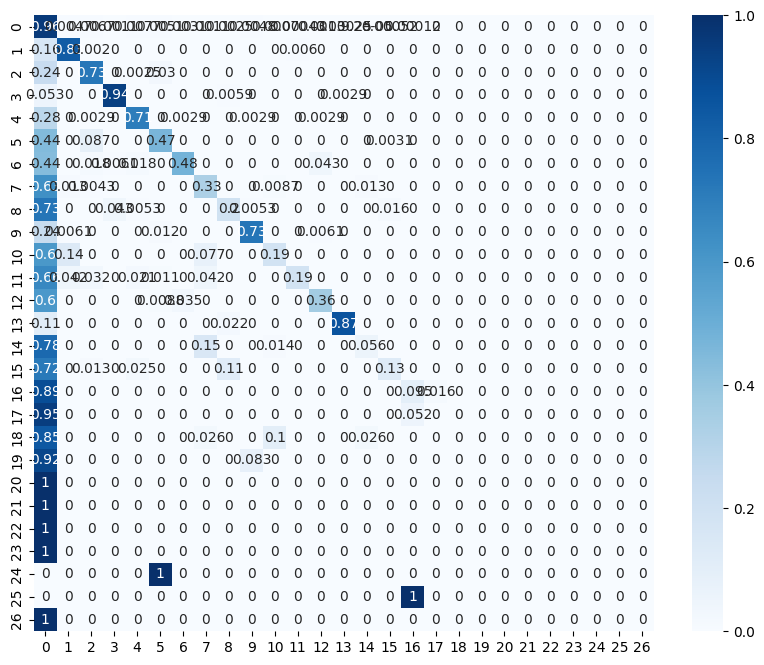

Test, F1 macro:  0.51  Loss :  0.31


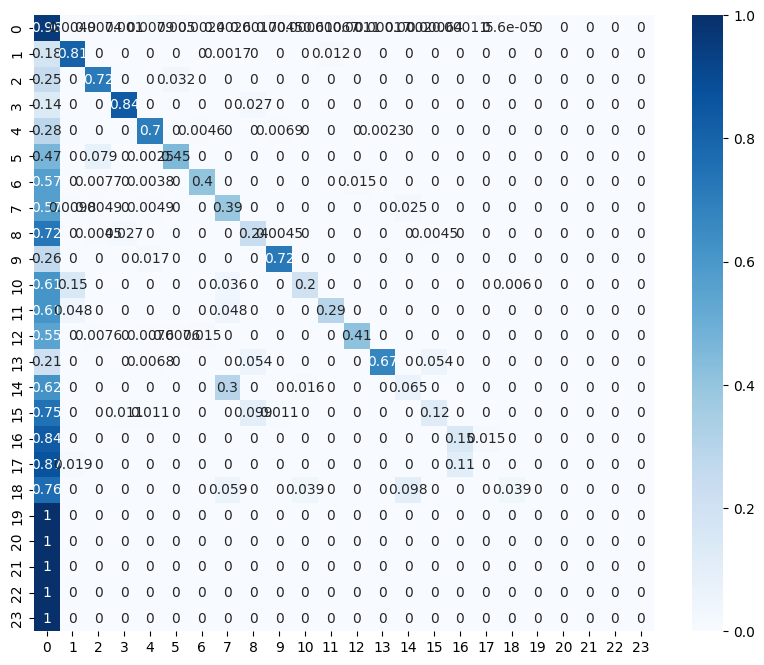

In [ ]:
model = LSTMTagger(EMBEDDING_DIM, 64, len(word_to_ix), len(tag_to_ix), DistilRoBERTa, 3)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.2)

for epoch in range(22):
    print("Epoch:",epoch)
    acc, loss = evaluate(train, targets_train, train = True)
    print("Train, F1 macro: ", acc, " Loss : ", loss)
    with torch.no_grad():
      acc, loss = evaluate(validation, targets_val, cnf_mtrx = True)
      print("Val,   F1 macro: ", acc, " Loss : ", loss)
      plt.show()

with torch.no_grad():
  acc, loss = evaluate(test, targets_test, cnf_mtrx = True)
  print("Test, F1 macro: ", acc, " Loss : ", loss)
  plt.show()